In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
base = "drive/My Drive/외부/공모전/[기상] AI프렌즈 시즌1 온도 추정 경진대회/"

data = pd.read_csv(os.path.join(base, "train.csv"))

### 똑같은 값만 나오는 센서 삭제

In [4]:
broken_cols = data.columns[data.max() == data.min()]
print(broken_cols)

for col in broken_cols:
  data = data.drop(columns=col)

Index(['X14', 'X16', 'X19'], dtype='object')


In [0]:
X_cols = [col for col in data.columns if 'X' in col]
Y_cols = ["Y{0:02}".format(i) for i in range(18)]

train = data[:4320]
val = data[4320:]

### 센서 데이터 시각화

In [0]:
sensors = {
  'temperature' : ["X00","X07","X28","X31","X32"], #기온
  'localpress'  : ["X01","X06","X22","X27","X29"], #현지기압
  'speed'       : ["X02","X03","X18","X24","X26"], #풍속
  'water'       : ["X04","X10","X21","X36","X39"], #일일 누적강수량
  'press'       : ["X05","X08","X09","X23","X33"], #해면기압
  'sun'         : ["X11","X34"], #일일 누적일사량
  'humidity'    : ["X12","X20","X30","X37","X38"], #습도
  'direction'   : ["X13","X15","X17","X25","X35"], #풍향
}

In [19]:
for Y in Y_cols:
  mae = mean_absolute_error(train[Y], train[sensors['temperature']].mean(axis=1))

  print(f"{Y} : {mae}")
print(f"Y18 : {mean_absolute_error(val['Y18'], val[sensors['temperature']].mean(axis=1))}")

Y00 : 1.3452268518518518
Y01 : 3.2918518518518516
Y02 : 3.246648148148148
Y03 : 4.15911574074074
Y04 : 4.173819444444444
Y05 : 3.823152777777778
Y06 : 2.9416342592592595
Y07 : 3.6814999999999998
Y08 : 3.9465185185185185
Y09 : 3.882134259259259
Y10 : 4.92449074074074
Y11 : 6.328708333333333
Y12 : 3.9668888888888887
Y13 : 1.3096203703703702
Y14 : 1.8672962962962962
Y15 : 2.066847222222222
Y16 : 3.5242824074074077
Y17 : 4.046560185185185
Y18 : 3.584166666666667


In [22]:
sum_mae = 0

for Y in Y_cols:
  Y_bar = [y for y in Y_cols if y != Y]
  mae = mean_absolute_error(train[Y], train[sensors['temperature'] + Y_bar].mean(axis=1))
  sum_mae += mae

  print(f"{Y} : {mae}")

print(f"Y18 : {mean_absolute_error(val['Y18'], val[sensors['temperature']].mean(axis=1))}")

Y00 : 2.98017781986532
Y01 : 1.778520622895623
Y02 : 1.6482554713804713
Y03 : 5.003662668350168
Y04 : 4.980657617845118
Y05 : 1.9210574494949495
Y06 : 2.3805250420875423
Y07 : 2.735848063973064
Y08 : 2.5429713804713807
Y09 : 2.4749400252525255
Y10 : 3.436883417508418
Y11 : 4.815847011784512
Y12 : 2.784648569023569
Y13 : 1.787752525252525
Y14 : 2.230364057239057
Y15 : 1.5726020622895622
Y16 : 1.9427767255892259
Y17 : 2.656901304713805
Y18 : 3.584166666666667


In [0]:
mae = mean_absolute_error(train[Y_cols].mean(axis=1), train[sensors['temperature']].mean(axis=1))

In [10]:
mean_absolute_error(val['Y18'], val[sensors['temperature']].mean(axis=1))

3.584166666666667

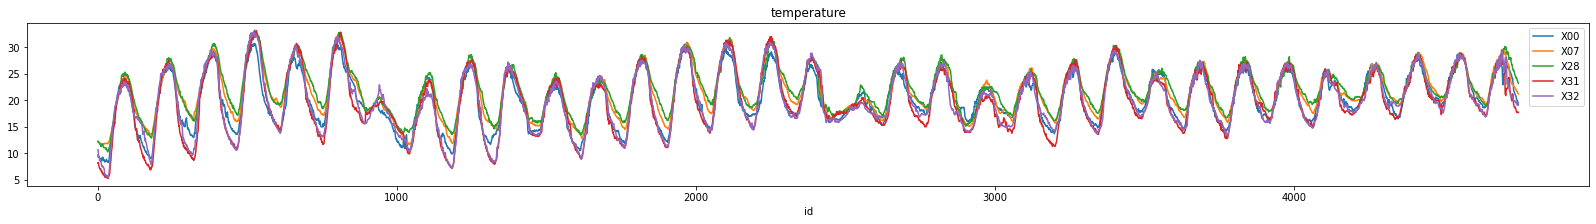

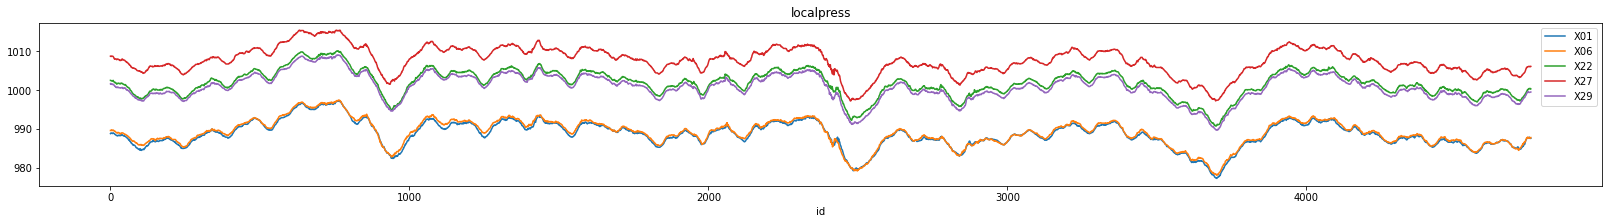

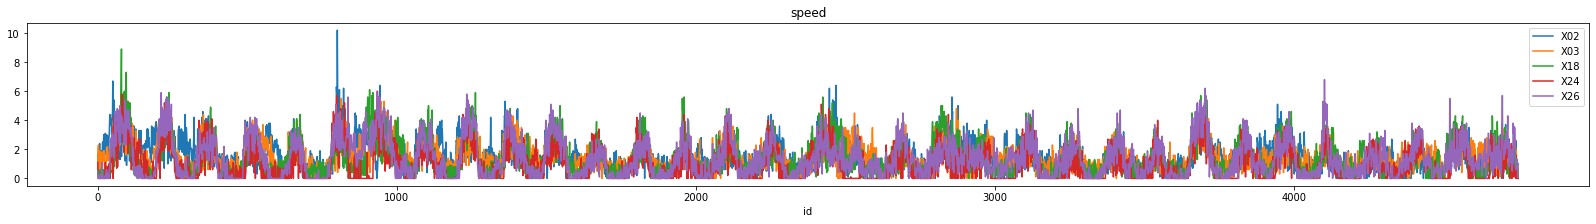

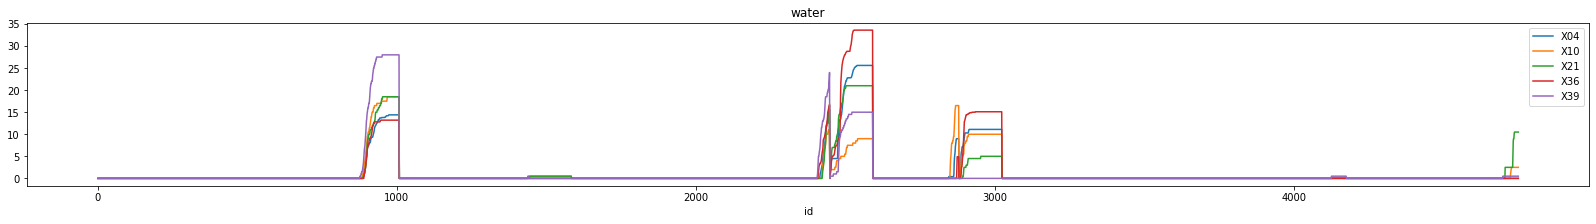

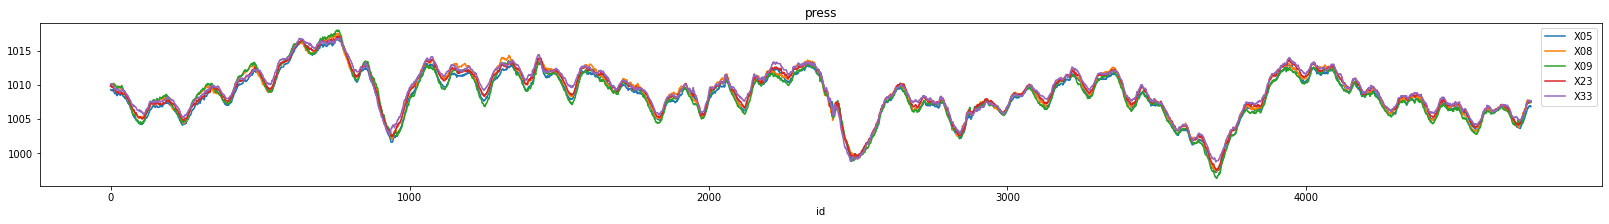

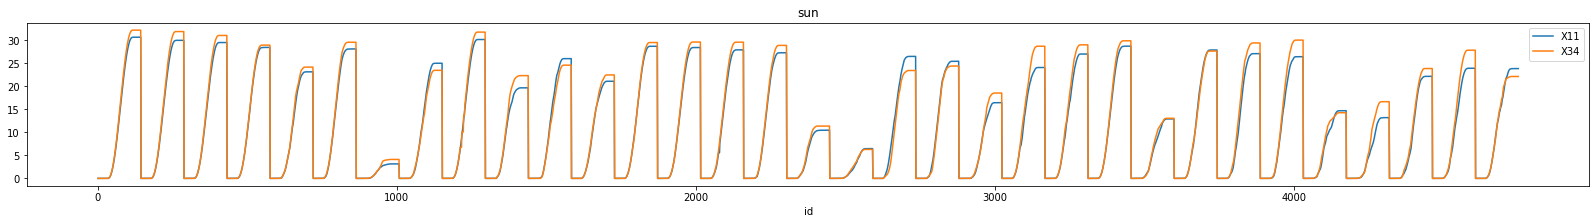

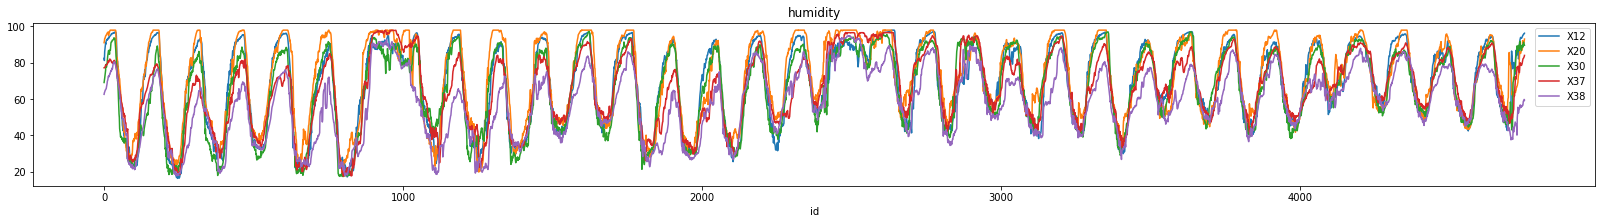

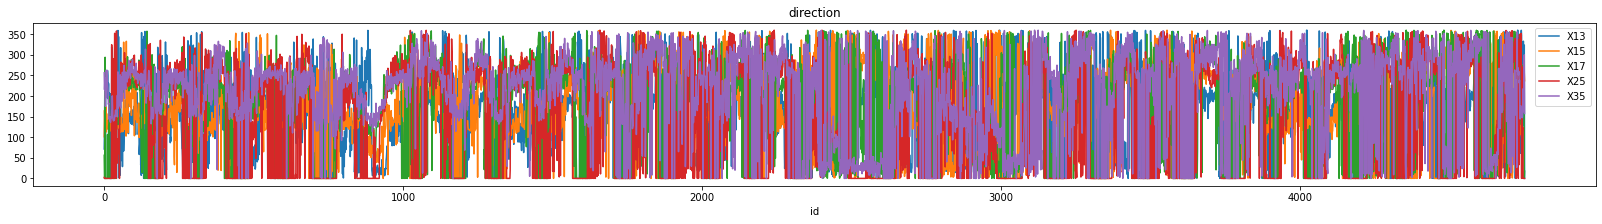

In [0]:
for name, cols in sensors.items():
  data.plot(x='id', y=cols, figsize=(28,3), title=name)

In [0]:
train_temp = train[sensors['temperature'] + Y_cols]
train_temp.corr()

,X00,X07,X28,X31,X32,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
X00,1.000000,0.957432,0.942055,0.961906,0.964011,0.912809,0.951641,0.954500,0.729502,0.728564,0.906096,0.840827,0.746129,0.902829,0.947931,0.945833,0.933180,0.825280,0.951228,0.911123,0.925800,0.923968,0.911654
X07,0.957432,1.000000,0.982814,0.955101,0.961933,0.979172,0.970238,0.973252,0.841002,0.840372,0.892414,0.795471,0.698961,0.897089,0.923403,0.931275,0.911746,0.778135,0.958731,0.931548,0.906402,0.891921,0.885659
X28,0.942055,0.982814,1.000000,0.938471,0.940381,0.974490,0.953917,0.958521,0.857562,0.856534,0.864041,0.752037,0.652907,0.872612,0.889321,0.899919,0.879923,0.733078,0.938310,0.916300,0.874344,0.855365,0.849162
X31,0.961906,0.955101,0.938471,1.000000,0.980342,0.918779,0.956140,0.957152,0.758773,0.758412,0.899776,0.838379,0.743822,0.896547,0.947002,0.947893,0.932860,0.817218,0.950045,0.915336,0.919587,0.917060,0.905867
X32,0.964011,0.961933,0.940381,0.980342,1.000000,0.921823,0.956146,0.960426,0.747431,0.746524,0.901241,0.852777,0.763417,0.894345,0.951074,0.950790,0.936655,0.830264,0.950898,0.906674,0.929539,0.923795,0.911813
Y00,0.912809,0.979172,0.974490,0.918779,0.921823,1.000000,0.945462,0.947184,0.920752,0.919972,0.817688,0.690335,0.585850,0.836851,0.850780,0.869858,0.844218,0.663123,0.909656,0.897737,0.826532,0.798885,0.798477
Y01,0.951641,0.970238,0.953917,0.956140,0.956146,0.945462,1.000000,0.996363,0.807446,0.808103,0.913400,0.799784,0.699600,0.932933,0.954373,0.967733,0.959880,0.786007,0.966648,0.943079,0.920245,0.909008,0.919950
Y02,0.954500,0.973252,0.958521,0.957152,0.960426,0.947184,0.996363,1.000000,0.804464,0.804596,0.911885,0.814001,0.719153,0.927811,0.955915,0.965284,0.959697,0.796121,0.965006,0.935583,0.927460,0.913493,0.920502
Y03,0.729502,0.841002,0.857562,0.758773,0.747431,0.920752,0.807446,0.804464,1.000000,0.997148,0.612025,0.437006,0.323399,0.660726,0.638645,0.677301,0.638896,0.403811,0.737742,0.757141,0.606391,0.564290,0.569647
Y04,0.728564,0.840372,0.856534,0.758412,0.746524,0.919972,0.808103,0.804596,0.997148,1.000000,0.611630,0.435704,0.322691,0.661284,0.638685,0.676703,0.638006,0.403173,0.736848,0.760139,0.604150,0.563474,0.571673


In [23]:
train_temp = val[sensors['temperature'] + ['Y18']]
train_temp.corr()

,X00,X07,X28,X31,X32,Y18
X00,1.000000,0.944908,0.924129,0.937889,0.924167,0.847230
X07,0.944908,1.000000,0.946606,0.933640,0.962667,0.832904
X28,0.924129,0.946606,1.000000,0.846107,0.883669,0.766648
X31,0.937889,0.933640,0.846107,1.000000,0.948696,0.871901
X32,0.924167,0.962667,0.883669,0.948696,1.000000,0.871631
Y18,0.847230,0.832904,0.766648,0.871901,0.871631,1.000000


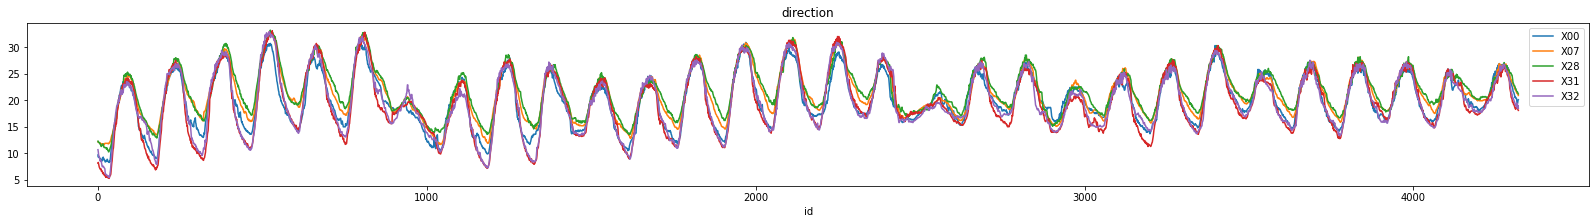

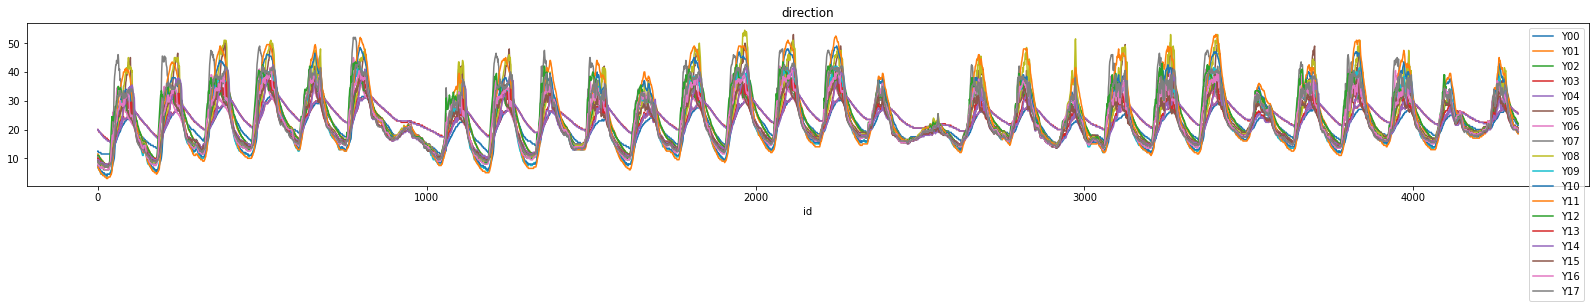

In [0]:
train.plot(x='id', y=sensors['temperature'], figsize=(28,3), title=name)
train.plot(x='id', y=Y_cols, figsize=(28,3), title=name)

### Feature Selection

In [0]:
def forward_selection(clf, dataset, X_cols):
  sfs = SFS(clf, 
            k_features=len(X_cols), 
            forward=True, 
            floating=False, 
            scoring='neg_mean_squared_error',
            cv=10)

  sfs = sfs.fit(dataset[X_cols], dataset['Y18'])
  fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
  plt.title('Sequential Forward Selection (w. StdErr)')
  plt.grid()
  plt.show()

  return sfs

def print_good_features(sfs):
  metric = sfs.get_metric_dict()
  avg_scores = dict()
  max_key = None

  for key in metric.keys():
    avg_scores[metric[key]['feature_names']] = metric[key]['avg_score']

  for key, score in sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:2]:
    if max_key is None: max_key = key
    
    print("feature_names: {}, avg_score: {}".format(key, score))

    return max_key

def check_cross_val_score(clf, dataset, X_cols, cv=5):
  scores = cross_val_score(clf, val[X_cols], val['Y18'], cv=cv)

  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### LinearRegression을 이용한 forward Seletion

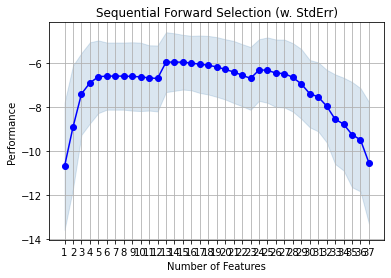

feature_names: ('X02', 'X04', 'X05', 'X12', 'X17', 'X22', 'X23', 'X26', 'X29', 'X30', 'X35', 'X36', 'X37', 'X38'), avg_score: -5.9594847740007335


In [25]:
sfs = forward_selection(LinearRegression(), val, X_cols)
features = print_good_features(sfs)

In [26]:
lr_feature_name = list(features)
check_cross_val_score(LinearRegression(), val, lr_feature_name)

Accuracy: 0.70 (+/- 0.43)


### Ridge을 이용한 forward Seletion

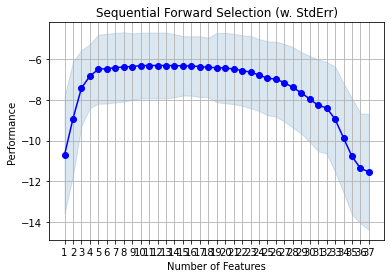

feature_names: ('X05', 'X06', 'X08', 'X12', 'X22', 'X23', 'X29', 'X30', 'X35', 'X36', 'X37', 'X38'), avg_score: -6.303022288469515


In [27]:
sfs = forward_selection(Ridge(alpha=1.0), val, X_cols)
features = print_good_features(sfs)

In [28]:
ridge_feature_name = list(features)
check_cross_val_score(Ridge(alpha=1.0), val, ridge_feature_name)

Accuracy: 0.74 (+/- 0.19)


### Univariate Selection
- Ref: https://wikidocs.net/16599

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

selectK = SelectKBest(score_func=f_classif, k=8)
X = selectK.fit_transform(val[X_cols], val['Y18'])

for col in X_cols:
  if list(val[col])[0] in X[0]:
    print("'{}'".format(col), end=", ")
print()

'X00', 'X07', 'X12', 'X20', 'X30', 'X31', 'X32', 'X37', 


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 33] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Feature Importance

In [30]:
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, 8)
fit = rfe.fit(val[X_cols], val['Y18'])

print(f"Num Features: {fit.n_features_}")
print(f"Selected Features: {np.array(X_cols)[fit.support_]}")
print(f"Feature Ranking: {np.array(X_cols)[fit.ranking_]}")

Num Features: 8
Selected Features: ['X01' 'X06' 'X09' 'X23' 'X27' 'X29' 'X33' 'X39']
Feature Ranking: ['X13' 'X01' 'X27' 'X23' 'X32' 'X17' 'X01' 'X03' 'X06' 'X01' 'X25' 'X05'
 'X24' 'X29' 'X30' 'X31' 'X18' 'X21' 'X11' 'X15' 'X01' 'X22' 'X28' 'X10'
 'X01' 'X08' 'X01' 'X12' 'X02' 'X20' 'X01' 'X04' 'X26' 'X33' 'X07' 'X09'
 'X01']


### recursive feature elimination
- 재귀적으로 특징 제거
- 시간이 오래 걸린다

In [0]:
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVR
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(val[X_cols], val['Y18'])

# print(f"Selected Features: {np.array(X_cols)[selector.support_]}")
# print(f"Feature Ranking: {np.array(X_cols)[selector.ranking_]}")

### Model Selection

In [0]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', LogisticRegression())])

param_grid = [{'classifier': [SVR()], 
              'classifier__gamma': [0.01, 0.1, 1, 10, 100], 
              'classifier__C': [0.01, 0.1, 1, 10, 100]
              },

               {'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'], 
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
               },

              {'classifier': [RandomForestClassifier()],
              'classifier__max_depth': [4, 6], # max_depth: The maximum depth of the tree.
              'classifier__n_estimators': [50, 100], # n_estimators: The number of trees in the forest.
              'classifier__min_samples_split': [50, 100]
              }] # min_samples_split: The minimum number of samples required to split an internal node       

grid = GridSearchCV(pipe, param_grid, scoring = 'roc_auc', cv=5)  
grid.fit(val[X_cols], val['Y18'])

print(grid.best_params_)
print(grid.best_score_)

In [0]:
feature_names = {'lr': lr_feature_name,
                 'ridge': ridge_feature_name,
                 'selectK':['X00', 'X07', 'X12', 'X20', 'X30', 'X31', 'X32', 'X37'],
                 'rfe': ['X01', 'X06', 'X09', 'X23', 'X27', 'X29', 'X33', 'X39']}

### lightbgm으로 예측하기

In [33]:
train['Y18'] = train[Y_cols].mean(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
def train_lgb(dataset, X_cols, Y_col='Y18'):
    lgb_train = lgb.Dataset(dataset[X_cols], label=dataset[Y_col])

    lgb_param = {
        'objective': 'regression',
        'metrics': 'mae',
        'learning_rate' : 0.01
    }

    cv_result = lgb.cv(
        lgb_param,
        lgb_train,
        num_boost_round=99999,
        nfold = 5,
        early_stopping_rounds=50,
        stratified=False,
        verbose_eval=10
    )

    lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result['l1-mean'])
    )

    return lgb_model

def get_val_accuracy(clf, X_cols, Y_col='Y18'):
  pred = clf.predict(val[X_cols])
  mae = mean_absolute_error(val[Y_col], pred)

  return mae

def submit(clf, X_cols, name="None"):
  submit = pd.read_csv(base + 'sample_submission.csv')
  test = pd.read_csv(base + "test.csv")
  submit['Y18'] = clf.predict(test[X_cols])

  submit.to_csv(os.path.join(base, "제출", name + ".csv"), index=None)

In [35]:
results = dict()

for name, features in feature_names.items():
  lgb_model = train_lgb(train, features)

  val_accuracy = get_val_accuracy(lgb_model, features)

  print(f"feature_name: {name}, val_accracy: {val_accuracy}")
  results[name] = val_accuracy

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[8460]	cv_agg's l1: 1.07281 + 0.0286252
[8470]	cv_agg's l1: 1.07277 + 0.0286172
[8480]	cv_agg's l1: 1.07274 + 0.0286381
[8490]	cv_agg's l1: 1.07272 + 0.02864
[8500]	cv_agg's l1: 1.07269 + 0.0286553
[8510]	cv_agg's l1: 1.07268 + 0.0286479
[8520]	cv_agg's l1: 1.07265 + 0.0286328
[8530]	cv_agg's l1: 1.07263 + 0.0286311
[8540]	cv_agg's l1: 1.07259 + 0.0286317
[8550]	cv_agg's l1: 1.07259 + 0.0286236
[8560]	cv_agg's l1: 1.07256 + 0.0286286
[8570]	cv_agg's l1: 1.07251 + 0.0286037
[8580]	cv_agg's l1: 1.07249 + 0.0285944
[8590]	cv_agg's l1: 1.07246 + 0.0285846
[8600]	cv_agg's l1: 1.07241 + 0.0285769
[8610]	cv_agg's l1: 1.07238 + 0.028585
[8620]	cv_agg's l1: 1.07236 + 0.0285769
[8630]	cv_agg's l1: 1.07234 + 0.0285825
[8640]	cv_agg's l1: 1.07234 + 0.0285929
[8650]	cv_agg's l1: 1.07229 + 0.0285978
[8660]	cv_agg's l1: 1.07227 + 0.0286017
[8670]	cv_agg's l1: 1.07223 + 0.0286083
[8680]	cv_agg's l1: 1.07221 + 0.0286006
[8690]	cv_agg's l1: 1.07217 + 0.0285955
[8700]	

In [36]:
max_name = None

for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
  if max_name is None : max_name = name
  print(f"feature_name: {name}, val_accracy: {accuracy}")

feature_name: rfe, val_accracy: 3.429388638719239
feature_name: lr, val_accracy: 3.142590109469947
feature_name: ridge, val_accracy: 3.015678801582096
feature_name: selectK, val_accracy: 2.1082297877378973


### Submit

In [0]:
total_data = pd.concat([train, val], axis=0)

In [38]:
lgb_model = train_lgb(total_data, feature_names[max_name])
submit(lgb_model, feature_names[max_name], "lightbgm_selectK")

[10]	cv_agg's l1: 5.80836 + 0.0877569
[20]	cv_agg's l1: 5.51333 + 0.0829076
[30]	cv_agg's l1: 5.24809 + 0.077783
[40]	cv_agg's l1: 5.00893 + 0.0741713
[50]	cv_agg's l1: 4.79097 + 0.074481
[60]	cv_agg's l1: 4.59158 + 0.0772426
[70]	cv_agg's l1: 4.4082 + 0.0765101
[80]	cv_agg's l1: 4.2414 + 0.0742241
[90]	cv_agg's l1: 4.08783 + 0.0711395
[100]	cv_agg's l1: 3.95016 + 0.0693716
[110]	cv_agg's l1: 3.82249 + 0.0685745
[120]	cv_agg's l1: 3.70574 + 0.0705353
[130]	cv_agg's l1: 3.60016 + 0.0713482
[140]	cv_agg's l1: 3.5047 + 0.0706669
[150]	cv_agg's l1: 3.41734 + 0.0700122
[160]	cv_agg's l1: 3.33937 + 0.0715514
[170]	cv_agg's l1: 3.2686 + 0.0727734
[180]	cv_agg's l1: 3.2044 + 0.0731073
[190]	cv_agg's l1: 3.14514 + 0.0716829
[200]	cv_agg's l1: 3.08975 + 0.072353
[210]	cv_agg's l1: 3.03825 + 0.0737131
[220]	cv_agg's l1: 2.99094 + 0.0742701
[230]	cv_agg's l1: 2.94849 + 0.0754785
[240]	cv_agg's l1: 2.90811 + 0.0753783
[250]	cv_agg's l1: 2.87072 + 0.0749848
[260]	cv_agg's l1: 2.83413 + 0.0745546
[27